# LangGraph Detailed Tutorial

> **Build a Customer Support Agent from scratch — step by step.**
>
> Each step solves a problem from the previous step. Covers **every core LangGraph concept** — from simple graphs to production deployment.

| Pinned to | Version |
|---|---|
| langgraph | 0.3.x |
| langchain-openai | 0.3.x |
| Python | 3.11+ |
| Last verified | 2026-02-06 |

If code breaks, check the [LangGraph changelog](https://github.com/langchain-ai/langgraph/releases).

## Setup & Installation

Run this cell first to install all required packages.

In [1]:
%%capture
!pip install langgraph langchain-openai langchain-core pydantic IPython

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

# Set your OpenAI API key (or load from .env)
# os.environ["OPENAI_API_KEY"] = "sk-..."

assert os.environ.get("OPENAI_API_KEY"), "Please set OPENAI_API_KEY"
print("API key loaded successfully.")

API key loaded successfully.


---
## Step 1: The Simplest Graph

**Goal:** Understand the building blocks — **State**, **Nodes**, **Edges**.

Every LangGraph app is a **state machine**: data flows through nodes, and edges decide what happens next.

### Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E8F5E9', 'primaryTextColor': '#1B5E20', 'primaryBorderColor': '#4CAF50', 'lineColor': '#4CAF50', 'secondaryColor': '#FFF3E0', 'tertiaryColor': '#E3F2FD'}}}%%
graph LR
    START(["__start__"]) --> greet["greet"]
    greet -->|"'order' in message"| order_handler["order_handler"]
    greet -->|"otherwise"| general_handler["general_handler"]
    order_handler --> END(["__end__"])
    general_handler --> END
```

**Key concepts:**
- **State** = a TypedDict that carries data between nodes
- **Node** = a Python function that receives state and returns updates
- **Edge** = connects nodes (normal = always, conditional = based on state)
- **START/END** = special entry and exit points
- By default, node return values **overwrite** state keys

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# 1. STATE: The data that flows through your graph
class State(TypedDict):
    message: str

# 2. NODES: Functions that read state and return updates
def greet(state: State):
    return {"message": state["message"] + " Welcome to Acme Support!"}

def classify(state: State) -> str:
    # This will become smarter later
    if "order" in state["message"].lower():
        return "order_handler"
    return "general_handler"

def order_handler(state: State):
    return {"message": state["message"] + " [Routed to Orders]"}

def general_handler(state: State):
    return {"message": state["message"] + " [Routed to General]"}

# 3. BUILD THE GRAPH
builder = StateGraph(State)
builder.add_node("greet", greet)
builder.add_node("order_handler", order_handler)
builder.add_node("general_handler", general_handler)

# 4. EDGES: Connect the nodes
builder.add_edge(START, "greet")                    # Always start here
builder.add_conditional_edges("greet", classify)     # Route based on state
builder.add_edge("order_handler", END)
builder.add_edge("general_handler", END)

# 5. COMPILE & RUN
graph = builder.compile()
result = graph.invoke({"message": "I need help with my order"})
print(result["message"])

I need help with my order Welcome to Acme Support! [Routed to Orders]


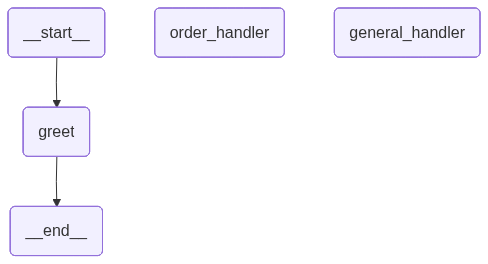

In [4]:
# Visualize the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Try the other path — general handler
result = graph.invoke({"message": "Hello, I have a question"})
print(result["message"])

Hello, I have a question Welcome to Acme Support! [Routed to General]


**What we have:** A basic workflow that routes requests.

**Problem:** It's just string manipulation. We need an LLM to understand users.

---
## Step 2: Add an LLM (Chain)

**Problem from Step 1:** Our nodes are hardcoded. We need the LLM to generate intelligent responses.

**Solution:** Use **MessagesState** (a pre-built state with a messages list) and a chat model.

### Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E3F2FD', 'primaryTextColor': '#0D47A1', 'primaryBorderColor': '#2196F3', 'lineColor': '#2196F3'}}}%%
graph LR
    START(["__start__"]) --> chatbot["chatbot\n(LLM call)"]
    chatbot --> END(["__end__"])
```

**Why MessagesState?** It uses the `add_messages` **reducer** — when a node returns messages, they get **appended** to the list instead of replacing it. This is critical for conversation history.

```python
# Under the hood, MessagesState is:
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]  # add_messages = append reducer
```

In [8]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

# MessagesState has a built-in `messages` list with an `add_messages` reducer
# This means new messages APPEND instead of overwrite
llm = ChatOpenAI(model="gpt-4o")

def chatbot(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}  # Appended, not overwritten!

builder = StateGraph(MessagesState)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()
result = graph.invoke({"messages": [HumanMessage(content="Hi, I need support")]})
print(result["messages"][-1].content)

Of course! How can I assist you today?


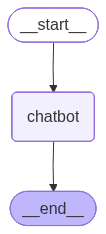

In [9]:
# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

**What we have:** LLM-powered chatbot.

**Problem:** It can only talk. It can't look up orders, search docs, or take actions.

---
## Step 3: Add Tools — The Router Pattern

**Problem from Step 2:** The LLM can only generate text. We need it to call functions.

**Solution:** **Bind tools** to the LLM. Add a **ToolNode** to execute them. Use **tools_condition** to route.

### Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#FFF3E0', 'primaryTextColor': '#E65100', 'primaryBorderColor': '#FF9800', 'lineColor': '#FF9800'}}}%%
graph LR
    START(["__start__"]) --> assistant["assistant\n(LLM + tools)"]
    assistant -->|"tool_call"| tools["tools\n(ToolNode)"]
    assistant -->|"no tool_call"| END(["__end__"])
    tools --> END
```

This is the **Router** pattern: the LLM decides whether to call a tool or respond directly.

**Problem:** After the tool runs, the result goes to END. The LLM **never sees the tool output!**

In [10]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

# Define tools the agent can use
@tool
def search_orders(customer_name: str) -> str:
    """Search for customer orders by name."""
    orders = {"Alice": "Order #123: Laptop, arriving tomorrow",
              "Bob": "Order #456: Mouse, delivered"}
    return orders.get(customer_name, "No orders found")

@tool
def check_shipping(order_id: str) -> str:
    """Check shipping status for an order."""
    return f"Order {order_id}: In transit, ETA 2 days"

tools = [search_orders, check_shipping]
llm_with_tools = ChatOpenAI(model="gpt-4o").bind_tools(tools)

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))  # Pre-built: executes tool calls

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition  # Routes to "tools" if LLM made a tool call, else END
)
builder.add_edge("tools", END)  # After tool runs, END

graph = builder.compile()

result = graph.invoke({"messages": [HumanMessage(content="Check orders for Alice")]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Check orders for Alice
================================== Ai Message ==================================
Tool Calls:
  search_orders (call_snLBds1C2QhxUYdycqAeaDCO)
 Call ID: call_snLBds1C2QhxUYdycqAeaDCO
  Args:
    customer_name: Alice
================================= Tool Message =================================
Name: search_orders

Order #123: Laptop, arriving tomorrow


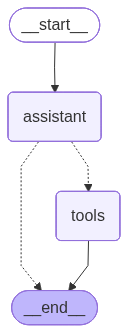

In [11]:
# Visualize the Router pattern
display(Image(graph.get_graph().draw_mermaid_png()))

Notice the LLM calls the tool, but the tool result goes straight to END. The LLM never gets to reason about the tool output!

---
## Step 4: The ReAct Agent Loop

**Problem from Step 3:** Tool results go to END — the LLM never sees them and can't reason about them.

**Solution:** Loop the tool output **back to the assistant**. This creates the **ReAct pattern**: Reason -> Act -> Observe -> Repeat.

### Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#F3E5F5', 'primaryTextColor': '#4A148C', 'primaryBorderColor': '#9C27B0', 'lineColor': '#9C27B0'}}}%%
graph LR
    START(["__start__"]) --> assistant["assistant\n(Reason)"]
    assistant -->|"tool_call"| tools["tools\n(Act)"]
    assistant -->|"no tool_call"| END(["__end__"])
    tools -->|"Observe result"| assistant
```

**The ReAct loop:**
1. User asks question
2. Assistant decides: call a tool or respond
3. If tool call -> tool executes -> result goes **back to assistant**
4. Assistant sees result, decides: call another tool or respond
5. Repeat until assistant responds without tool calls -> END

In [12]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="You are a helpful customer support agent for Acme Corp.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")  # KEY CHANGE: loop back!

graph = builder.compile()

# Now the agent can chain multiple tool calls
result = graph.invoke({
    "messages": [HumanMessage(content="Check my orders. My name is Alice. Then check the shipping.")]
})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Check my orders. My name is Alice. Then check the shipping.
================================== Ai Message ==================================
Tool Calls:
  search_orders (call_wGRBGLNjatQqxEoh2sQRlvoI)
 Call ID: call_wGRBGLNjatQqxEoh2sQRlvoI
  Args:
    customer_name: Alice
================================= Tool Message =================================
Name: search_orders

Order #123: Laptop, arriving tomorrow
================================== Ai Message ==================================
Tool Calls:
  check_shipping (call_l3ho035NvsDReoesImGv5SA5)
 Call ID: call_l3ho035NvsDReoesImGv5SA5
  Args:
    order_id: 123
================================= Tool Message =================================
Name: check_shipping

Order 123: In transit, ETA 2 days
================================== Ai Message ==================================

I found your order: a Laptop, expected to arrive tomorrow. However, the curre

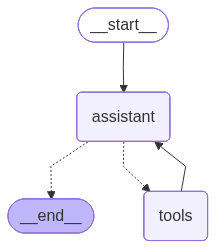

In [13]:
# Visualize the ReAct loop
display(Image(graph.get_graph().draw_mermaid_png()))

**What we have:** A real agent that reasons and acts.

**Problem:** It forgets everything between calls.

---
## Step 5: Add Memory (Checkpointer)

**Problem from Step 4:** Each `invoke()` is independent. The agent forgets the entire conversation.

**Solution:** Add a **checkpointer** that saves state after every step. Use **thread_id** to identify conversations.

### Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E8F5E9', 'primaryTextColor': '#1B5E20', 'primaryBorderColor': '#4CAF50', 'lineColor': '#4CAF50'}}}%%
graph TD
    subgraph "Thread: alice-support-1"
        A["Message 1"] --> B["Checkpoint 1"]
        B --> C["Message 2"]
        C --> D["Checkpoint 2"]
        D --> E["Message 3"]
        E --> F["Checkpoint 3"]
    end
    subgraph "Thread: bob-support-1"
        G["Message 1"] --> H["Checkpoint 1"]
        H --> I["Message 2"]
        I --> J["Checkpoint 2"]
    end
```

**How it works:**
- `MemorySaver` saves a **checkpoint** (full state snapshot) after every graph step
- `thread_id` identifies which conversation to load/save
- Different `thread_id` = different conversation

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

# Same graph as Step 4, but compiled with a checkpointer
graph = builder.compile(checkpointer=MemorySaver())

# thread_id identifies the conversation
config = {"configurable": {"thread_id": "alice-support-1"}}

# First message
result = graph.invoke(
    {"messages": [HumanMessage(content="Hi, I'm Alice. Check my orders.")]},
    config
)
print("--- First message ---")
print(result["messages"][-1].content)

# Second message — REMEMBERS because same thread_id
result = graph.invoke(
    {"messages": [HumanMessage(content="What was my order number?")]},
    config  # Same thread = same memory
)
print("\n--- Second message (remembers!) ---")
print(result["messages"][-1].content)

In [ ]:
# Different thread = no memory of previous conversation
config_new = {"configurable": {"thread_id": "bob-support-1"}}
result = graph.invoke(
    {"messages": [HumanMessage(content="What was my order number?")]},
    config_new
)
print("--- Different thread (no memory) ---")
print(result["messages"][-1].content)

**What we have:** Agent with conversation memory.

**Problem:** We need to track more than just messages — like customer tier, escalation status, etc.

---
## Step 6: Custom State, Schemas & Reducers

**Problem from Step 5:** MessagesState only has `messages`. We need custom fields (customer info, ticket status) and proper validation.

**Solution:** Define **custom state** with extra keys. Use **reducers** to control how updates work. Use **Pydantic** for validation. Use **separate input/output schemas** to hide internal state.

### Reducer Behavior

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#FFFDE7', 'primaryTextColor': '#F57F17', 'primaryBorderColor': '#FFC107', 'lineColor': '#FFC107'}}}%%
graph TD
    subgraph "Default: Overwrite"
        A1["customer_name = 'Alice'"] -->|"return {'customer_name': 'Bob'}"| A2["customer_name = 'Bob'"]
    end
    subgraph "Reducer: operator.add (Append)"
        B1["action_log = ['searched']"] -->|"return {'action_log': ['called']}"| B2["action_log = ['searched', 'called']"]
    end
    subgraph "Reducer: add_messages (Append)"
        C1["messages = [msg1]"] -->|"return {'messages': [msg2]}"| C2["messages = [msg1, msg2]"]
    end
```

### 6.1 Custom State Keys

In [ ]:
from langgraph.graph import MessagesState

class SupportState(MessagesState):
    # Extra keys beyond messages
    customer_name: str
    customer_tier: str  # "standard" or "premium"
    escalated: bool

print("SupportState fields:", list(SupportState.__annotations__.keys()))

### 6.2 Reducers — Control How State Updates

In [ ]:
import operator
from typing import Annotated

class StateWithReducers(MessagesState):
    customer_name: str                                    # Default: overwrite
    action_log: Annotated[list, operator.add]             # Reducer: append lists
    escalated: bool

# Custom reducer for edge cases
def safe_add(left: list | None, right: list | None) -> list:
    """Handles None values gracefully."""
    return (left or []) + (right or [])

class StateWithSafeReducer(MessagesState):
    action_log: Annotated[list, safe_add]

print("Reducer demo: operator.add([1,2], [3,4]) =", operator.add([1, 2], [3, 4]))
print("Safe reducer: safe_add(None, ['action']) =", safe_add(None, ["action"]))

### 6.3 Pydantic Validation

In [ ]:
from pydantic import BaseModel, field_validator

class ValidatedState(BaseModel):
    customer_name: str
    customer_tier: str

    @field_validator('customer_tier')
    def validate_tier(cls, v):
        if v not in ["standard", "premium"]:
            raise ValueError("Tier must be 'standard' or 'premium'")
        return v

# This works
valid = ValidatedState(customer_name="Alice", customer_tier="premium")
print(f"Valid: {valid}")

# This raises a validation error
try:
    invalid = ValidatedState(customer_name="Alice", customer_tier="gold")
except ValueError as e:
    print(f"Validation error (expected): {e}")

### 6.4 Input/Output Schemas — Hide Internal State

In [ ]:
from typing_extensions import TypedDict

class InputState(TypedDict):   # What the caller provides
    messages: list

class OutputState(TypedDict):  # What the caller gets back
    messages: list
    resolution: str

class FullState(InputState):   # Internal — caller never sees this
    customer_tier: str
    escalated: bool
    action_log: list

# Use separate schemas:
# builder = StateGraph(FullState, input=InputState, output=OutputState)
print("InputState keys:", list(InputState.__annotations__.keys()))
print("OutputState keys:", list(OutputState.__annotations__.keys()))
print("FullState keys:", list(FullState.__annotations__.keys()))

> **Warning:** Parallel nodes writing to the same key will **FAIL** without a reducer! If two nodes run in parallel and both write to the same field, you need a reducer to merge the results.

**What we have:** Rich state with validation and clean API boundaries.

**Problem:** Long conversations use too many tokens (expensive and slow).

---
## Step 7: Manage Long Conversations

**Problem from Step 6:** After 20+ messages, the context is huge. Token costs skyrocket, responses slow down.

**Solution:** Three strategies: **trim**, **filter**, or **summarize** old messages.

### Strategy Comparison

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#FCE4EC', 'primaryTextColor': '#880E4F', 'primaryBorderColor': '#E91E63', 'lineColor': '#E91E63'}}}%%
graph TD
    LONG["20+ messages\n(expensive!)"] --> TRIM["Trim\nKeep last N tokens"]
    LONG --> FILTER["Filter\nRemove tool messages"]
    LONG --> SUMMARIZE["Summarize\nCompress into summary"]
    TRIM --> RESULT1["Fast but loses context"]
    FILTER --> RESULT2["Moderate savings"]
    SUMMARIZE --> RESULT3["Best of both worlds"]
```

### 7.1 Trim Messages (by token count)

In [ ]:
from langchain_core.messages import trim_messages, AIMessage

# Create a sample long conversation
long_conversation = [
    SystemMessage(content="You are a support agent."),
    HumanMessage(content="I need help with billing"),
    AIMessage(content="I'd be happy to help with billing."),
    HumanMessage(content="My account number is 12345"),
    AIMessage(content="I found your account. What's the issue?"),
    HumanMessage(content="I was charged twice for my subscription"),
    AIMessage(content="I see the duplicate charge. Let me fix that."),
    HumanMessage(content="When will the refund appear?"),
]

# Trim to keep only the most recent messages (by token count)
trimmed = trim_messages(
    long_conversation,
    max_tokens=100,
    token_counter=llm,     # Use the LLM's tokenizer
    strategy="last",       # Keep most recent
    include_system=True    # Always keep system message
)

print(f"Original: {len(long_conversation)} messages")
print(f"Trimmed: {len(trimmed)} messages")
for m in trimmed:
    print(f"  [{m.type}] {m.content[:60]}..." if len(m.content) > 60 else f"  [{m.type}] {m.content}")

### 7.2 Filter Messages (by type)

In [ ]:
def filter_tool_messages(messages: list) -> list:
    """Remove tool call/result messages to save tokens."""
    return [m for m in messages if m.type in ("human", "ai", "system") and not getattr(m, 'tool_calls', None)]

# Demo
filtered = filter_tool_messages(long_conversation)
print(f"Filtered: {len(filtered)} messages (from {len(long_conversation)})")

### 7.3 Summarize (best of both worlds)

Keep a running summary so no context is truly lost.

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E8F5E9', 'primaryTextColor': '#1B5E20', 'primaryBorderColor': '#4CAF50', 'lineColor': '#4CAF50'}}}%%
graph LR
    START(["__start__"]) --> assistant["assistant"]
    assistant -->|"tool_call"| tools["tools"]
    assistant -->|"no tool_call, msgs > 6"| summarize["summarize"]
    assistant -->|"no tool_call, msgs <= 6"| END(["__end__"])
    tools --> assistant
    summarize --> END
```

In [ ]:
from langchain_core.messages import RemoveMessage

class SummarizedState(MessagesState):
    summary: str  # Holds conversation summary

def summarize_conversation(state: SummarizedState):
    summary = state.get("summary", "")

    if summary:
        summary_prompt = (
            f"Existing summary: {summary}\n\n"
            "Extend the summary with the new messages above:"
        )
    else:
        summary_prompt = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    new_summary = ChatOpenAI(model="gpt-4o").invoke(messages).content

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": new_summary, "messages": delete_messages}

def should_summarize(state: SummarizedState):
    """Trigger summarization when conversation gets long."""
    if len(state["messages"]) > 6:
        return "summarize"
    return END

print("Summarization functions defined.")
print("This pattern keeps a running summary while trimming old messages.")

**What we have:** Efficient long conversations.

**Problem:** MemorySaver stores everything in RAM — restart the app and all conversations are gone.

---
## Step 8: Persistent Memory (External Storage)

**Problem from Step 7:** `MemorySaver` is in-memory. Server restart = all conversations lost.

**Solution:** Use a **database-backed checkpointer** for production.

### Checkpointer Options

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E3F2FD', 'primaryTextColor': '#0D47A1', 'primaryBorderColor': '#2196F3', 'lineColor': '#2196F3'}}}%%
graph LR
    DEV["Development"] --> MEM["MemorySaver\n(RAM)"]
    SINGLE["Single Server"] --> SQL["SqliteSaver\n(disk file)"]
    MULTI["Multi Server"] --> PG["PostgresSaver\n(database)"]
```

| Checkpointer | Persists where | When to use |
|---|---|---|
| `MemorySaver` | RAM (lost on restart) | Development, testing |
| `SqliteSaver` | SQLite file on disk | Single-server production |
| `PostgresSaver` | PostgreSQL database | Multi-server production |

In [ ]:
# Development: RAM (fast, temporary)
from langgraph.checkpoint.memory import MemorySaver
memory_checkpointer = MemorySaver()
print("MemorySaver: In-memory, fast, data lost on restart")

# Production (single server): SQLite
# from langgraph.checkpoint.sqlite import SqliteSaver
# with SqliteSaver.from_conn_string("checkpoints.db") as checkpointer:
#     graph = builder.compile(checkpointer=checkpointer)
print("SqliteSaver: File-based, persistent, single server")

# Production (multi-server): PostgreSQL
# from langgraph.checkpoint.postgres import PostgresSaver
# with PostgresSaver.from_conn_string("postgresql://...") as checkpointer:
#     graph = builder.compile(checkpointer=checkpointer)
print("PostgresSaver: Database-backed, distributed, multi-server")

**What we have:** Persistent conversations that survive restarts.

**Problem:** Users stare at a blank screen waiting for the full response.

---
## Step 9: Streaming

**Problem from Step 8:** `invoke()` waits for the entire graph to finish. Users see nothing until the end.

**Solution:** **Stream** tokens and state updates in real-time.

### Streaming Modes

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#FFF3E0', 'primaryTextColor': '#E65100', 'primaryBorderColor': '#FF9800', 'lineColor': '#FF9800'}}}%%
graph TD
    STREAM["graph.stream()"] --> VALUES["stream_mode='values'\nFull state after each node"]
    STREAM --> MESSAGES["stream_mode='messages'\nIndividual token chunks"]
    STREAM --> ASYNC["graph.astream()\nAsync streaming"]
```

### 9.1 Stream Full State After Each Node

In [ ]:
# Rebuild the ReAct agent with memory for streaming demo
builder = StateGraph(MessagesState)
builder.add_node("assistant", lambda state: {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]})
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
graph = builder.compile(checkpointer=MemorySaver())

config = {"configurable": {"thread_id": "stream-demo"}}

print("=== Stream Mode: values (full state after each node) ===")
for event in graph.stream(
    {"messages": [HumanMessage(content="Check orders for Alice")]},
    config,
    stream_mode="values"  # Full state after each node
):
    event["messages"][-1].pretty_print()

### 9.2 Stream Individual Tokens (typing effect)

In [ ]:
config2 = {"configurable": {"thread_id": "stream-demo-2"}}

print("=== Stream Mode: messages (individual token chunks) ===")
for event in graph.stream(
    {"messages": [HumanMessage(content="Tell me about Acme Corp's return policy in 2 sentences.")]},
    config2,
    stream_mode="messages"  # Individual message chunks
):
    msg, metadata = event
    if msg.content and metadata.get("langgraph_node") == "assistant":
        print(msg.content, end="", flush=True)  # Real-time typing
print()  # newline at end

**What we have:** Real-time streaming responses.

**Problem:** The agent executes tools automatically — what if a tool sends an email or makes a purchase?

---
## Step 10: Human-in-the-Loop (Breakpoints)

**Problem from Step 9:** Tools execute without approval. Dangerous for actions like sending emails, refunding money, or deleting data.

**Solution:** Add **breakpoints** to pause before tool execution. The human reviews, then resumes.

### Flow with Breakpoint

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#FFEBEE', 'primaryTextColor': '#B71C1C', 'primaryBorderColor': '#F44336', 'lineColor': '#F44336'}}}%%
graph LR
    START(["__start__"]) --> assistant["assistant"]
    assistant -->|"tool_call"| PAUSE{{"PAUSE\nHuman Review"}}
    PAUSE -->|"Approve"| tools["tools"]
    PAUSE -->|"Edit/Reject"| assistant
    assistant -->|"no tool_call"| END(["__end__"])
    tools --> assistant
```

### 10.1 Static Breakpoints

In [ ]:
# Compile with interrupt_before
graph_with_hitl = builder.compile(
    checkpointer=MemorySaver(),
    interrupt_before=["tools"]  # PAUSE before running any tool
)

config = {"configurable": {"thread_id": "approval-demo"}}

# Step 1: Run until breakpoint
print("=== Step 1: Run until breakpoint ===")
for event in graph_with_hitl.stream(
    {"messages": [HumanMessage(content="Check orders for Alice")]},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

# Step 2: Inspect what's pending
print("\n=== Step 2: Inspect pending state ===")
state = graph_with_hitl.get_state(config)
print(f"Next node: {state.next}")
print(f"Pending tool calls: {state.values['messages'][-1].tool_calls}")

In [ ]:
# Step 3: Human approves -> resume
print("=== Step 3: Human approves, resuming... ===")
for event in graph_with_hitl.stream(None, config, stream_mode="values"):  # None = continue
    event["messages"][-1].pretty_print()

### 10.2 Edit State Before Resuming

The human can **modify** what the agent is about to do.

In [ ]:
config_edit = {"configurable": {"thread_id": "edit-demo"}}

# Run until breakpoint
for event in graph_with_hitl.stream(
    {"messages": [HumanMessage(content="Check orders for Bob")]},
    config_edit,
    stream_mode="values"
):
    pass

print("Paused before tools. Let's edit the state...")

# Inject a human message to change course
graph_with_hitl.update_state(
    config_edit,
    {"messages": [HumanMessage(content="Actually, check orders for Alice instead.")]}
)

# Resume with modified state
print("\nResuming with edited state...")
for event in graph_with_hitl.stream(None, config_edit, stream_mode="values"):
    event["messages"][-1].pretty_print()

### 10.3 Dynamic Breakpoints (inside nodes)

Pause conditionally from **inside** a node using `interrupt()`:

```python
from langgraph.types import interrupt

@tool
def refund_order(order_id: str) -> str:
    """Process a refund for an order. Requires human approval."""
    answer = interrupt({"question": f"Approve refund for {order_id}? (yes/no)"})
    if answer.lower() != "yes":
        return "Refund cancelled by human."
    return f"Refund processed for {order_id}"
```

**What we have:** Safe agent with human oversight.

**Problem:** Something went wrong 5 steps ago. How do we debug it?

---
## Step 11: Time Travel

**Problem from Step 10:** The agent made a mistake earlier in the conversation. We need to go back and try a different path.

**Solution:** Browse the **state history** and **fork** from any past checkpoint.

### Time Travel Visualization

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E8EAF6', 'primaryTextColor': '#1A237E', 'primaryBorderColor': '#3F51B5', 'lineColor': '#3F51B5'}}}%%
graph TD
    S1["Step 1: User asks"] --> S2["Step 2: Agent calls tool A"]
    S2 --> S3["Step 3: Tool A result"]
    S3 --> S4["Step 4: Agent responds (wrong!)"]
    S3 -.->|"Fork here!"| S4B["Step 4B: Try different tool"]
    S4B --> S5B["Step 5B: Better response"]
    
    style S4 fill:#FFCDD2,stroke:#F44336
    style S4B fill:#C8E6C9,stroke:#4CAF50
    style S5B fill:#C8E6C9,stroke:#4CAF50
```

### 11.1 Browse History

In [ ]:
# Using our approval-demo thread which has history
config = {"configurable": {"thread_id": "approval-demo"}}

print("=== State History ===")
for state in graph_with_hitl.get_state_history(config):
    print(f"Step {state.metadata.get('step', '?')}: next={state.next}, "
          f"messages={len(state.values.get('messages', []))}")

### 11.2 Fork From a Past State

In [ ]:
# Get all history
all_states = list(graph_with_hitl.get_state_history(config))
print(f"Total checkpoints: {len(all_states)}")

if len(all_states) >= 2:
    # Go back to an earlier state
    past_state = all_states[-2]  # Second from the beginning
    print(f"\nForking from step {past_state.metadata.get('step', '?')}...")
    
    # Modify that past state and run from there
    graph_with_hitl.update_state(
        past_state.config,
        {"messages": [HumanMessage(content="Actually, check shipping for order 456")]}
    )
    
    # This creates a NEW timeline from that point
    print("Running from forked state...")
    for event in graph_with_hitl.stream(None, past_state.config, stream_mode="values"):
        event["messages"][-1].pretty_print()
else:
    print("Not enough history to demo forking.")

**Use cases:**
- **Debug:** See exactly what the agent did at each step
- **Retry:** Go back and try a different tool call
- **A/B test:** Fork from the same point and compare different paths

**What we have:** Full debuggability and replay.

**Problem:** Some tasks are independent (search orders + check FAQ) but run sequentially. Slow!

---
## Step 12: Parallel Execution, Sub-graphs & Map-Reduce

**Problem from Step 11:** Independent tasks run one after another. Wastes time.

### 12.1 Static Parallelism

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#F3E5F5', 'primaryTextColor': '#4A148C', 'primaryBorderColor': '#9C27B0', 'lineColor': '#9C27B0'}}}%%
graph TD
    classify["classify"] --> search_orders["search_orders"]
    classify --> search_faq["search_faq"]
    classify --> check_history["check_history"]
    search_orders --> aggregate["aggregate"]
    search_faq --> aggregate
    check_history --> aggregate
```

Multiple edges from the same source = parallel execution.

In [ ]:
# Demo: Static Parallelism
from typing import Annotated
import operator

class ParallelState(TypedDict):
    query: str
    results: Annotated[list, operator.add]  # Must use reducer for parallel writes!

def classify(state: ParallelState):
    return {}  # Just passes through

def search_orders_node(state: ParallelState):
    return {"results": [f"Orders result for: {state['query']}"]}

def search_faq_node(state: ParallelState):
    return {"results": [f"FAQ result for: {state['query']}"]}

def check_history_node(state: ParallelState):
    return {"results": [f"History result for: {state['query']}"]}

def aggregate(state: ParallelState):
    return {"results": [f"\nAggregated {len(state['results'])} results"]}

parallel_builder = StateGraph(ParallelState)
parallel_builder.add_node("classify", classify)
parallel_builder.add_node("search_orders", search_orders_node)
parallel_builder.add_node("search_faq", search_faq_node)
parallel_builder.add_node("check_history", check_history_node)
parallel_builder.add_node("aggregate", aggregate)

parallel_builder.add_edge(START, "classify")
parallel_builder.add_edge("classify", "search_orders")    # These three run
parallel_builder.add_edge("classify", "search_faq")       # in PARALLEL
parallel_builder.add_edge("classify", "check_history")
parallel_builder.add_edge("search_orders", "aggregate")   # All must complete
parallel_builder.add_edge("search_faq", "aggregate")      # before aggregate
parallel_builder.add_edge("check_history", "aggregate")
parallel_builder.add_edge("aggregate", END)

parallel_graph = parallel_builder.compile()
result = parallel_graph.invoke({"query": "laptop order", "results": []})
print("Results:")
for r in result["results"]:
    print(f"  - {r}")

In [ ]:
# Visualize parallel execution
display(Image(parallel_graph.get_graph().draw_mermaid_png()))

### 12.2 Sub-graphs (Reusable Workflows)

Complex workflows have reusable parts. Sub-graphs are like functions.

In [ ]:
# Build a reusable order-lookup sub-graph
class OrderState(TypedDict):
    order_id: str
    order_details: str

def validate_order(state: OrderState):
    oid = state["order_id"]
    return {"order_details": f"Order {oid} validated"}

def fetch_details(state: OrderState):
    return {"order_details": state["order_details"] + " | Details: Laptop, $999"}

sub_builder = StateGraph(OrderState)
sub_builder.add_node("validate_order", validate_order)
sub_builder.add_node("fetch_details", fetch_details)
sub_builder.add_edge(START, "validate_order")
sub_builder.add_edge("validate_order", "fetch_details")
sub_builder.add_edge("fetch_details", END)
order_lookup_graph = sub_builder.compile()

# Test the sub-graph independently
result = order_lookup_graph.invoke({"order_id": "123", "order_details": ""})
print(f"Sub-graph result: {result['order_details']}")

In [ ]:
# Visualize the sub-graph
display(Image(order_lookup_graph.get_graph().draw_mermaid_png()))

### 12.3 Map-Reduce (Dynamic Parallelism with Send)

**Unknown** number of parallel tasks at build time? Use the **Send** API.

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E0F7FA', 'primaryTextColor': '#006064', 'primaryBorderColor': '#00BCD4', 'lineColor': '#00BCD4'}}}%%
graph TD
    classify2["classify\n(fan-out)"] -->|"Send('process', {id: 1})"| P1["process_order\n(order 1)"]
    classify2 -->|"Send('process', {id: 2})"| P2["process_order\n(order 2)"]
    classify2 -->|"Send('process', {id: N})"| PN["process_order\n(order N)"]
    P1 --> agg2["aggregate"]
    P2 --> agg2
    PN --> agg2
```

In [ ]:
from langgraph.types import Send

class MapReduceState(TypedDict):
    order_ids: list[str]
    results: Annotated[list, operator.add]

class SingleOrderState(TypedDict):
    order_id: str
    results: Annotated[list, operator.add]

def fan_out_to_orders(state: MapReduceState):
    """Dynamically spawn one lookup per order."""
    return [
        Send("process_order", {"order_id": oid, "results": []})
        for oid in state["order_ids"]  # Could be 1 or 100 orders
    ]

def process_order(state: SingleOrderState):
    """Process a single order (runs in parallel for each Send)."""
    return {"results": [f"Processed order {state['order_id']}"]}

def aggregate_results(state: MapReduceState):
    """Collect all parallel results."""
    return {"results": [f"--- All {len(state['results'])} orders processed ---"]}

mr_builder = StateGraph(MapReduceState)
mr_builder.add_node("fan_out", lambda s: {})
mr_builder.add_node("process_order", process_order)
mr_builder.add_node("aggregate", aggregate_results)

mr_builder.add_edge(START, "fan_out")
mr_builder.add_conditional_edges("fan_out", fan_out_to_orders, ["process_order"])
mr_builder.add_edge("process_order", "aggregate")
mr_builder.add_edge("aggregate", END)

mr_graph = mr_builder.compile()

result = mr_graph.invoke({"order_ids": ["A1", "B2", "C3", "D4"], "results": []})
print("Map-Reduce Results:")
for r in result["results"]:
    print(f"  {r}")

**What we have:** Fast parallel execution with reusable components.

**Problem:** The agent remembers within a conversation but forgets Alice's preferences across different support tickets.

---
## Step 13: Long-Term Memory (Store)

**Problem from Step 12:** Checkpointer = memory within one thread. But when Alice opens a new ticket, the agent doesn't know she prefers email contact or that she's a premium customer.

**Solution:** Add a **Store** for cross-conversation memory. Checkpointer = short-term. Store = long-term.

### Memory Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E8F5E9', 'primaryTextColor': '#1B5E20', 'primaryBorderColor': '#4CAF50', 'lineColor': '#4CAF50'}}}%%
graph TD
    subgraph "Short-term (Checkpointer)"
        T1["Thread: ticket-100"] --> CP1["Messages for this chat"]
        T2["Thread: ticket-200"] --> CP2["Messages for this chat"]
    end
    subgraph "Long-term (Store)"
        U1["customers/alice/profile"] --> P1["name, tier, preferences"]
        U2["customers/alice/interactions"] --> P2["ticket-001, ticket-002, ..."]
    end
    T1 -.->|"reads"| U1
    T2 -.->|"reads"| U1
```

### 13.1 Basic Store Operations

In [ ]:
from langgraph.store.memory import InMemoryStore

store = InMemoryStore()

# Save user preferences (persists across ALL conversations)
namespace = ("customers", "alice")  # Like a folder path
store.put(namespace, "profile", {"name": "Alice", "tier": "premium"})
store.put(namespace, "preferences", {"contact": "email", "language": "en"})

# Retrieve later (from ANY conversation)
print("=== Alice's Long-Term Memory ===")
items = store.search(namespace)
for item in items:
    print(f"  {item.key}: {item.value}")

### 13.2 Use Store in Your Agent

In [ ]:
class StoreState(MessagesState):
    user_id: str

def assistant_with_memory(state: StoreState, *, store):
    """Agent that loads user profile from long-term memory."""
    user_id = state.get("user_id", "unknown")
    namespace = ("customers", user_id)

    # Load profile from store
    profile = {}
    for item in store.search(namespace):
        profile[item.key] = item.value

    system = SystemMessage(content=(
        f"You are a support agent. Customer profile: {profile}. "
        f"Personalize your response based on their tier and preferences."
    ))

    response = llm_with_tools.invoke([system] + state["messages"])
    return {"messages": [response]}

# Build graph with store
store_builder = StateGraph(StoreState)
store_builder.add_node("assistant", assistant_with_memory)
store_builder.add_node("tools", ToolNode(tools))
store_builder.add_edge(START, "assistant")
store_builder.add_conditional_edges("assistant", tools_condition)
store_builder.add_edge("tools", "assistant")

# Compile with BOTH checkpointer and store
store_graph = store_builder.compile(
    checkpointer=MemorySaver(),  # Short-term: this conversation
    store=store                   # Long-term: all conversations
)

# Thread 1 — Alice's first ticket
config1 = {"configurable": {"thread_id": "ticket-100", "user_id": "alice"}}
result = store_graph.invoke(
    {"messages": [HumanMessage(content="Hi, can you help me?")], "user_id": "alice"},
    config1
)
print("=== Ticket 100 (Alice) ===")
print(result["messages"][-1].content[:200])

# Thread 2 — Alice's SECOND ticket (different thread, same store!)
config2 = {"configurable": {"thread_id": "ticket-200", "user_id": "alice"}}
result = store_graph.invoke(
    {"messages": [HumanMessage(content="I have another question")], "user_id": "alice"},
    config2
)
print("\n=== Ticket 200 (Alice — remembers profile!) ===")
print(result["messages"][-1].content[:200])

### 13.3 Memory Patterns

**Profile pattern** (single record per user) vs **Collection pattern** (many items per user):

In [ ]:
# Profile pattern: One profile per user — update in place
store.put(("customers", "alice"), "profile", {
    "name": "Alice",
    "tier": "premium",
    "preferred_contact": "email",
    "notes": "Very technical, prefers detailed answers"
})

# Collection pattern: Multiple memories per user — build up over time
store.put(("customers", "alice", "interactions"), "ticket-001", {
    "date": "2024-01-15", "issue": "billing", "resolved": True
})
store.put(("customers", "alice", "interactions"), "ticket-002", {
    "date": "2024-02-20", "issue": "shipping", "resolved": True
})

# Search over past interactions
print("=== Alice's Interaction History ===")
past = store.search(("customers", "alice", "interactions"))
for item in past:
    print(f"  {item.key}: {item.value}")

**What we have:** Complete agent with short-term AND long-term memory.

**Problem:** Only works on your laptop.

---
## Step 14: Deploy to Production

**Problem from Step 13:** Agent only works locally. Need to serve it to real users.

### Deployment Architecture

```mermaid
%%{init: {'theme': 'base', 'themeVariables': {'primaryColor': '#E0F2F1', 'primaryTextColor': '#004D40', 'primaryBorderColor': '#009688', 'lineColor': '#009688'}}}%%
graph LR
    APP["Your App"] -->|"LangGraph SDK"| SERVER["LangGraph Server\n(Docker)"]
    SERVER --> GRAPH["support_agent graph"]
    SERVER --> DB[("PostgreSQL\nCheckpoints")]
    SERVER --> STORE[("Redis/DB\nLong-term Memory")]
```

### Double-Texting Strategies

| Strategy | What happens | When to use |
|---|---|---|
| `reject` | New message rejected while busy | Strict sequential processing |
| `enqueue` | Queued, runs after current finishes | Default — process everything |
| `interrupt` | Stops current run, starts new | Chat UX (latest message wins) |
| `rollback` | Undoes current, restarts from before | Idempotent operations |

In [ ]:
# Step 14.1: Create langgraph.json (shown as reference)
import json

langgraph_config = {
    "graphs": {
        "support_agent": "./agent.py:graph"
    },
    "dependencies": ["langchain", "langgraph", "langchain-openai"],
    "env": ".env"
}

print("langgraph.json configuration:")
print(json.dumps(langgraph_config, indent=2))

print("\n--- Deployment Commands ---")
print("1. langgraph build -t support-agent    # Build Docker image")
print("2. docker compose up                    # Run on port 8123")

print("\n--- SDK Usage (async) ---")
print("""
from langgraph_sdk import get_client

client = get_client(url="http://localhost:8123")
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    "support_agent",
    input={"messages": [{"role": "user", "content": "Hi"}]},
    config={"configurable": {"user_id": "alice"}}
):
    print(chunk.data)
""")

---
## Complete Code: Production-Ready Agent

Everything from Steps 1-14 combined into one working agent.

In [ ]:
from typing import Annotated, Literal
import operator
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.tools import tool

# --- State ---
class State(MessagesState):
    summary: str
    user_id: str
    action_log: Annotated[list, operator.add]

# --- Tools ---
@tool
def search_orders(customer_name: str) -> str:
    """Search for customer orders."""
    orders = {"Alice": "Order #123: Laptop", "Bob": "Order #456: Mouse"}
    return orders.get(customer_name, "No orders found")

@tool
def check_shipping(order_id: str) -> str:
    """Check shipping status."""
    return f"Order {order_id} arrives tomorrow"

tools = [search_orders, check_shipping]
llm = ChatOpenAI(model="gpt-4o").bind_tools(tools)
store = InMemoryStore()

# Seed some user data
store.put(("customers", "alice"), "profile", {
    "name": "Alice", "tier": "premium", "preferred_contact": "email"
})

# --- Nodes ---
def assistant(state: State, *, store):
    # Load long-term memory
    profile = {}
    if state.get("user_id"):
        for item in store.search(("customers", state["user_id"])):
            profile[item.key] = item.value

    system = SystemMessage(content=(
        f"Support agent. Profile: {profile}. "
        f"Summary: {state.get('summary', '')}"
    ))
    return {
        "messages": [llm.invoke([system] + state["messages"])],
        "action_log": ["llm_call"]
    }

def summarize(state: State):
    msgs_text = "\n".join([f"{m.type}: {m.content}" for m in state["messages"] if m.content])
    summary_prompt = f"Summarize this conversation:\n{msgs_text}"
    new_summary = ChatOpenAI(model="gpt-4o").invoke(summary_prompt).content
    delete = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": new_summary, "messages": delete}

def should_summarize(state: State) -> Literal["summarize", "__end__"]:
    return "summarize" if len(state["messages"]) > 10 else "__end__"

# --- Build Graph ---
builder = StateGraph(State)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize", summarize)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_conditional_edges("assistant", should_summarize)
builder.add_edge("summarize", END)

# --- Compile with All Features ---
graph = builder.compile(
    checkpointer=MemorySaver(),
    store=store,
    interrupt_before=["tools"]  # Human approval for tools
)

print("Production-ready agent compiled!")
print("Features: LLM, Tools, Memory, Store, HITL, Summarization")

In [ ]:
# Visualize the complete agent
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Run the complete agent
config = {"configurable": {"thread_id": "final-demo", "user_id": "alice"}}

print("=== Running complete agent ===")
for event in graph.stream(
    {"messages": [HumanMessage(content="Check my orders please")],
     "user_id": "alice", "action_log": []},
    config,
    stream_mode="values"
):
    event["messages"][-1].pretty_print()

# Check what's pending (HITL breakpoint)
state = graph.get_state(config)
if state.next:
    print(f"\nPaused at: {state.next}")
    print(f"Pending tool calls: {state.values['messages'][-1].tool_calls}")
    
    # Approve and continue
    print("\n--- Approving tool execution ---")
    for event in graph.stream(None, config, stream_mode="values"):
        event["messages"][-1].pretty_print()

---
## Summary: What We Built

| Step | Concept | Problem Solved |
|---|---|---|
| 1 | Simple graph (State, Nodes, Edges) | Need a structured workflow |
| 2 | LLM + MessagesState + Reducers | Need intelligent responses |
| 3 | Tools + ToolNode + tools_condition | LLM can't take actions |
| 4 | ReAct loop (tools -> assistant) | LLM can't see tool results |
| 5 | Checkpointer + thread_id | Agent forgets between calls |
| 6 | Custom state, Pydantic, I/O schemas | Need richer state + validation |
| 7 | Trim, filter, summarize messages | Long conversations = expensive |
| 8 | SQLite/Postgres checkpointer | Memory lost on restart |
| 9 | Streaming (values, messages, async) | Users wait for full response |
| 10 | Breakpoints + edit state + dynamic interrupt | Dangerous auto tool execution |
| 11 | get_state_history, fork, replay | Can't debug past mistakes |
| 12 | Parallel edges, sub-graphs, Send/map-reduce | Sequential = slow |
| 13 | InMemoryStore, namespaces, profiles | Forgets user across conversations |
| 14 | Docker, SDK, assistants, double-texting | Only works locally |

---

> **You now have a complete, production-ready customer support agent** that:
> - Remembers conversations (checkpointer)
> - Takes actions (tools)
> - Needs approval (interrupts)
> - Handles long chats (summarization)
> - Remembers users (store)
> - Runs in parallel (Send)
> - Is debuggable (time travel)
> - Is deployed (LangGraph Cloud)